In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from celluloid import Camera
from IPython.display import Audio
import librosa
import torch
from pathlib import Path
from Models.vae import VAE,VAEDeep,VAEDeeper
from datasets import SpectrogramDataset,DisentanglementDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from utils import get_bin_index,get_mutual_information
from Metrics.mig import mig
from Metrics.jemmig import jemmig
from Metrics.dci import dci
from Metrics.sap import sap
from Metrics.dcimig import dcimig
from Metrics.modularity import modularity

In [6]:
file_path = Path("/net/projects/scratch/summer/valid_until_31_January_2024/ybrima/data/learning/SyncSpeech/dataset_16k.npz")

dataset = DisentanglementDataset(file_path)

train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

In [17]:
num_models = 1

latent_dim = 8

x_batch, x_spec_batch, y_batch, frequency_batch, amplitude_batch = next(iter(train_loader))

CLASSES  =  dataset.CLASSES
x_batch,x_spec_batch, y_batch = next(iter(train_loader))
input_shape = x_spec_batch.shape

sr = dataset.sr
hop_length = 512

idx =  np.random.randint(0, x_spec_batch.shape[0])

device = "cuda" if torch.cuda.is_available() else "cpu"

In [92]:
n_latents  = 2
v_factor =  np.random.normal(0, 0.1, size=(10, n_latents))
z_latents = np.random.normal(0, 1, size=(10, n_latents))

#dci(v_factor, z_latents)

print(mig(v_factor, z_latents), jemmig(v_factor, z_latents), dcimig(v_factor, z_latents),modularity(v_factor, z_latents),sap(v_factor, z_latents))

0.11587745911735636 0.5324335904724022 0.02725508651197511 0.1545328713709102 0.08550624861471029


In [93]:
def compute_metrics(model_paths, dataloader, latent_dim=8):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    vae = VAEDeep(latent_dim, input_shape).to(device)
    
    z_list = []  # List to store all the latent vectors
    y_list = []  # List to store all the y_batch tensors
    frequency_list = []  # List to store all the frequency_batch tensors
    amplitude_list = []  # List to store all the amplitude_batch tensors
    history = {'model': ['vae', 'betavae', 'btcvae'], 'mig': [], 'jemmig': [], 'dcimig': [], 'modularity': [], 'sap': [] }
    for m in model_paths:
        state_dict = torch.load(m)
        vae.load_state_dict(state_dict)
        with torch.inference_mode():
            for x_batch, x_spec_batch, y_batch, frequency_batch, amplitude_batch in dataloader:
                x_spec_batch = x_spec_batch.to(device)
                x_hat, z_mean, z_logvar = vae(x_spec_batch.to(device))
                z = vae.reparameterize(z_mean, z_logvar)
                
                # Append the current batch of latent vectors to the list
                z_list.append(z.cpu().detach().numpy())
                
                # Append the current batch of y, frequency, and amplitude to their respective lists
                y_list.append(y_batch.cpu().detach().numpy())
                frequency_list.append(frequency_batch.cpu().detach().numpy())
                amplitude_list.append(amplitude_batch.cpu().detach().numpy())

        # Convert the lists to numpy arrays
        v_factors = np.concatenate(z_list, axis=0)
        all_labels = np.concatenate(y_list, axis=0)
        all_frequency = np.concatenate(frequency_list, axis=0)
        all_amplitude = np.concatenate(amplitude_list, axis=0)
        z_factors  = np.column_stack((all_labels, all_frequency, all_amplitude))
        history['mig'].append(mig(v_factors, z_factors))
        history['jemmig'].append(jemmig(v_factors, z_factors))
        history['dcimig'].append(dcimig(v_factors, z_factors))
        history['modularity'].append(modularity(v_factors, z_factors))
        history['sap'].append(sap(v_factors, z_factors))

    return history


In [98]:
model_list = ['./Exports/vae2deep_8.pth', './Exports/betavae2deep_8.pth','./Exports/btcvae2deep_8.pth' ]

history = compute_metrics(model_list, train_loader, latent_dim = 8)

In [100]:
df = pd.DataFrame(history)
df 

# convert df to latex table
print(df.to_latex(index=False))

\begin{tabular}{lrrrrr}
\toprule
model & mig & jemmig & dcimig & modularity & sap \\
\midrule
vae & 0.279308 & 0.301055 & 0.005984 & 0.665663 & 0.077424 \\
betavae & 0.100478 & 0.112004 & 0.001773 & 0.727914 & 0.025589 \\
btcvae & 0.078777 & 0.087934 & 0.006717 & 0.806770 & 0.014006 \\
\bottomrule
\end{tabular}



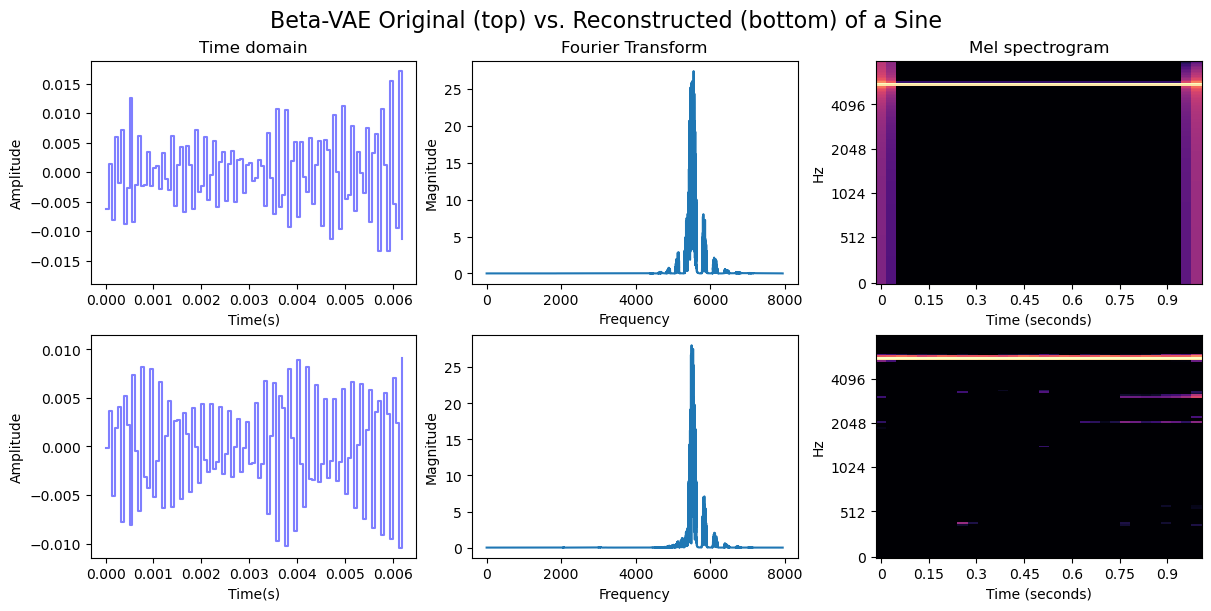

In [19]:
vae = VAEDeep(latent_dim, input_shape).to(device)
state_dict = torch.load(f'./Exports/vae2deep_{latent_dim}.pth')

# Load state dict
vae.load_state_dict(state_dict)

with torch.inference_mode():
  x_hat, z_mean, z_logvar = vae(x_spec_batch.to(device))


idx =  np.random.randint(0, x_hat.shape[0])
fig, axs = plt.subplots(2, 3, figsize=(12,6), constrained_layout=True)

# Extract mel specs 
mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
mel_spec_recon = x_hat[idx].squeeze().detach().cpu().numpy()

# Waveforms
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

librosa.display.waveshow(waveform[:100], sr=sr, color='b', ax=axs[0,0], alpha=0.5)
axs[0,0].set_xlabel('Time(s)')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].set_title('Time domain', fontsize=12)

waveform_recon = librosa.feature.inverse.mel_to_audio(mel_spec_recon, sr=sr, n_fft=2048, hop_length=512, n_iter=512)  
# axs[1,0].waveshow(waveform_recon, sr=sr, color='b')
librosa.display.waveshow(waveform_recon[:100], sr=sr, color='b', ax=axs[1,0], alpha=0.5)
axs[1,0].set_xlabel('Time(s)')
axs[1,0].set_ylabel('Amplitude')

# Fourier Transforms
ft = np.fft.fft(waveform)
axs[0,1].plot(np.abs(ft)[:len(ft)//2])
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('Magnitude')
axs[0,1].set_title('Fourier Transform', fontsize=12)

ft_recon = np.fft.fft(waveform_recon)
axs[1,1].plot(np.abs(ft_recon)[:len(ft_recon)//2]) 
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Magnitude')

# Mel spectrograms
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr, 
                  hop_length=hop_length,ax=axs[0,2])
axs[0,2].set_title('Mel spectrogram', fontsize=12)

librosa.display.specshow(librosa.power_to_db(mel_spec_recon, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr,
                  hop_length=hop_length, ax=axs[1,2])
# axs[1,2].set_title('Mel spectrogram')
                   
fig.suptitle(f'Beta-VAE Original (top) vs. Reconstructed (bottom) of a {CLASSES[y_batch[idx]].capitalize()}', fontsize=16)
# save the figure
plt.savefig('./Figures/Original_vs_Reconstructed.png', dpi=300, bbox_inches='tight')
plt.show()

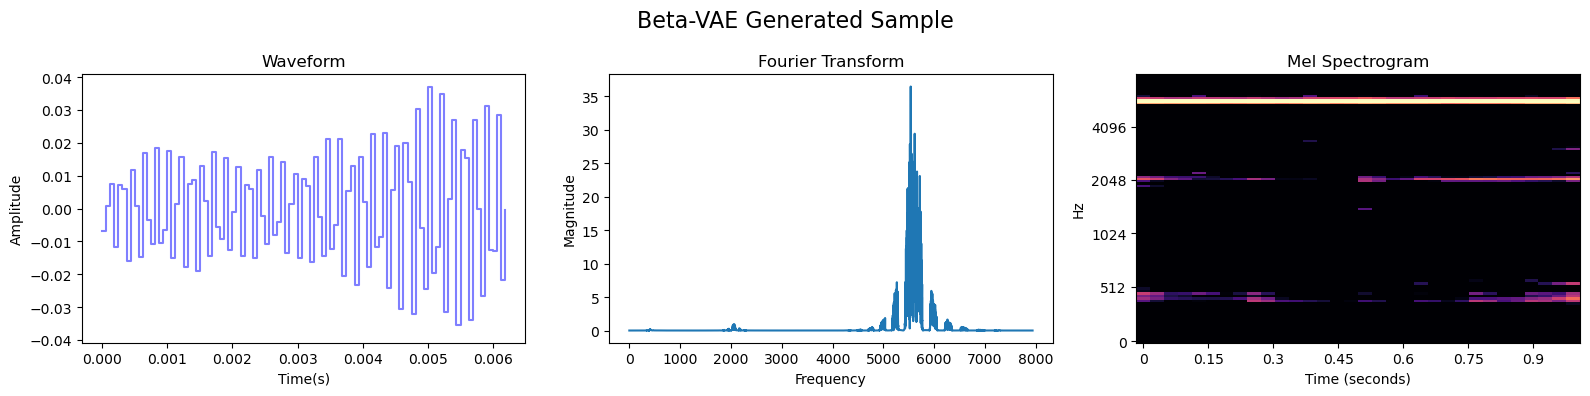

In [21]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_mel_spectrograms = vae.decode(latent_samples)  # Decode the latent samples

# Random generated mel spectrogram
# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

idx =  np.random.randint(len(generated_mel_spectrograms))
mel_spec = generated_mel_spectrograms[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

# Waveform
librosa.display.waveshow(waveform[:100], sr=sr, ax=axs[0], alpha=0.5, color='b')
axs[0].set_title('Waveform')
axs[0].set_xlabel('Time(s)')
axs[0].set_ylabel('Amplitude')

# Fourier Transform 
ft = np.fft.fft(waveform)
axs[1].plot(np.abs(ft)[:len(ft)//2])
axs[1].set_title('Fourier Transform')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Magnitude')

# Mel Spectrogram
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), 
                y_axis='mel', x_axis='s', sr=sr, 
                hop_length=hop_length, ax=axs[2])
axs[2].set_title('Mel Spectrogram')  
# axs[2].set_ylabel('Magnitude')
fig.suptitle('Beta-VAE Generated Sample', fontsize=16)  
plt.tight_layout()
# save the figure
plt.savefig('./Figures/Generated_sample.png', dpi=300, bbox_inches='tight')
plt.show()

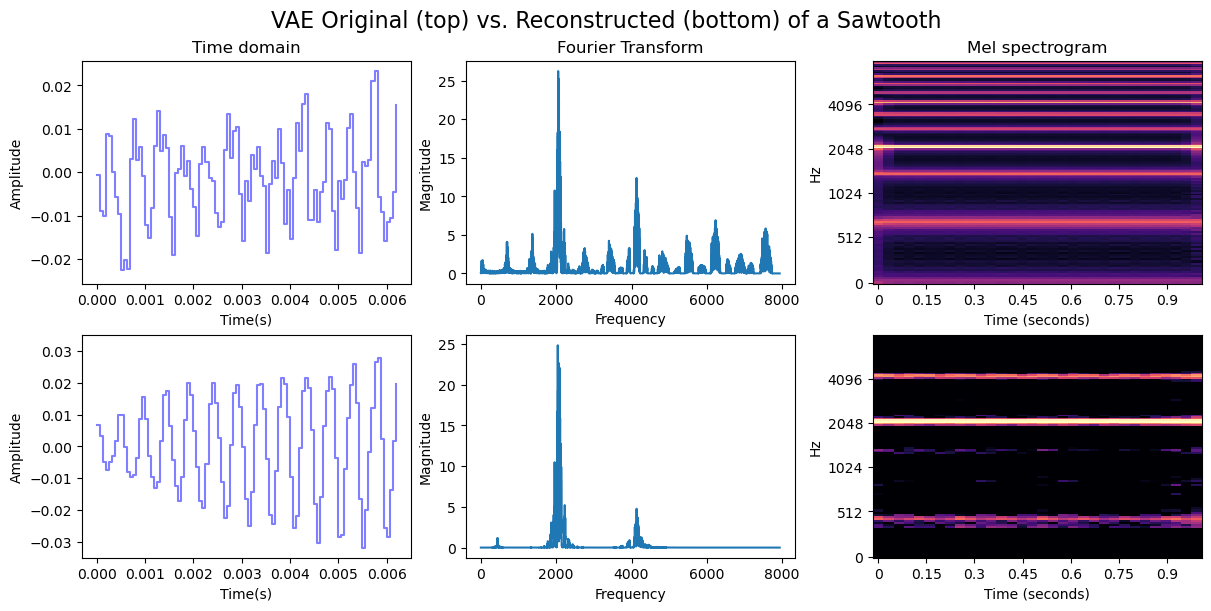

In [97]:
vae = VAEDeep(latent_dim, input_shape).to(device)
# state_dict = torch.load(f'./Exports/vae2deep_8_beta20.pth')
state_dict = torch.load(f'./Exports/betavae2deep_8.pth')

# Load state dict
vae.load_state_dict(state_dict)

with torch.inference_mode():
  x_hat, z_mean, z_logvar = vae(x_spec_batch.to(device))


idx =  np.random.randint(0, x_hat.shape[0])
fig, axs = plt.subplots(2, 3, figsize=(12,6), constrained_layout=True)

# Extract mel specs 
mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
mel_spec_recon = x_hat[idx].squeeze().detach().cpu().numpy()

# Waveforms
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

librosa.display.waveshow(waveform[:100], sr=sr, color='b', ax=axs[0,0], alpha=0.5)
axs[0,0].set_xlabel('Time(s)')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].set_title('Time domain', fontsize=12)

waveform_recon = librosa.feature.inverse.mel_to_audio(mel_spec_recon, sr=sr, n_fft=2048, hop_length=512, n_iter=512)  
# axs[1,0].waveshow(waveform_recon, sr=sr, color='b')
librosa.display.waveshow(waveform_recon[:100], sr=sr, color='b', ax=axs[1,0], alpha=0.5)
axs[1,0].set_xlabel('Time(s)')
axs[1,0].set_ylabel('Amplitude')

# Fourier Transforms
ft = np.fft.fft(waveform)
axs[0,1].plot(np.abs(ft)[:len(ft)//2])
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('Magnitude')
axs[0,1].set_title('Fourier Transform', fontsize=12)

ft_recon = np.fft.fft(waveform_recon)
axs[1,1].plot(np.abs(ft_recon)[:len(ft_recon)//2]) 
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Magnitude')

# Mel spectrograms
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr, 
                  hop_length=hop_length,ax=axs[0,2])
axs[0,2].set_title('Mel spectrogram', fontsize=12)

librosa.display.specshow(librosa.power_to_db(mel_spec_recon, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr,
                  hop_length=hop_length, ax=axs[1,2])
# axs[1,2].set_title('Mel spectrogram')
                   
fig.suptitle(f'VAE Original (top) vs. Reconstructed (bottom) of a {CLASSES[y_batch[idx]].capitalize()}', fontsize=16)
# save the figure
plt.savefig('./Figures/Original_vs_Reconstructed_VAE.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
mel_spec = x_hat[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
Audio(waveform, rate=sr)

In [24]:
mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
Audio(waveform, rate=sr)

In [25]:
Audio(x_batch[idx].squeeze().detach().cpu().numpy(), rate=sr)

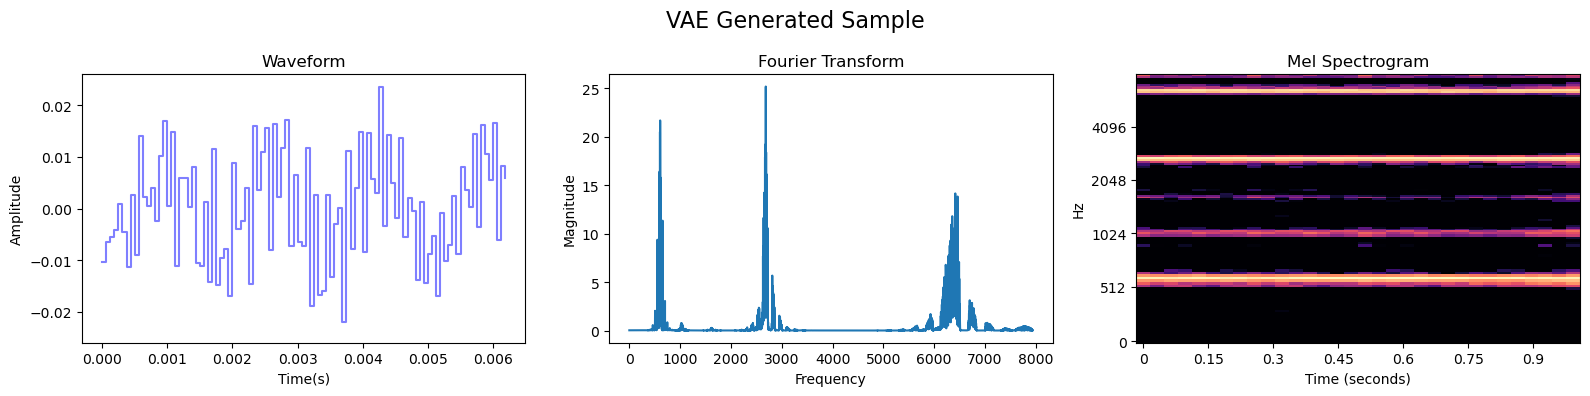

In [26]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_mel_spectrograms = vae.decode(latent_samples)  # Decode the latent samples

# Random generated mel spectrogram
# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

idx =  np.random.randint(len(generated_mel_spectrograms))
mel_spec = generated_mel_spectrograms[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

# Waveform
librosa.display.waveshow(waveform[:100], sr=sr, ax=axs[0], alpha=0.5, color='b')
axs[0].set_title('Waveform')
axs[0].set_xlabel('Time(s)')
axs[0].set_ylabel('Amplitude')

# Fourier Transform 
ft = np.fft.fft(waveform)
axs[1].plot(np.abs(ft)[:len(ft)//2])
axs[1].set_title('Fourier Transform')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Magnitude')

# Mel Spectrogram
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), 
                y_axis='mel', x_axis='s', sr=sr, 
                hop_length=hop_length, ax=axs[2])
axs[2].set_title('Mel Spectrogram')  
# axs[2].set_ylabel('Magnitude')
fig.suptitle('VAE Generated Sample', fontsize=16)  
plt.tight_layout()
# save the figure
plt.savefig('./Figures/Generated_sample_VAE.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_mel_spectrograms = vae.decode(latent_samples)  # Decode the latent samples

In [28]:
idx =  np.random.randint(len(generated_mel_spectrograms))
mel_spec = generated_mel_spectrograms[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

Audio(waveform, rate=sr)

In [30]:
mel_spec = x_hat[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
Audio(waveform, rate=sr)

IndexError: index 65 is out of bounds for dimension 0 with size 64

In [ ]:
mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)
Audio(waveform, rate=sr)

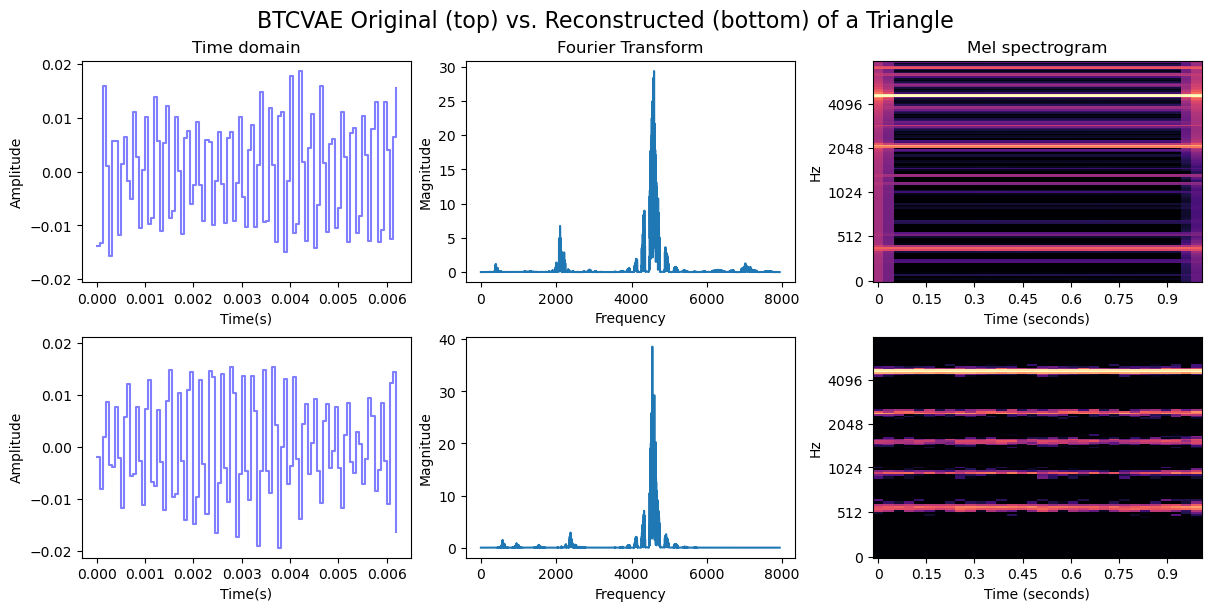

In [31]:
latent_dim = 8
device = "cuda" if torch.cuda.is_available() else "cpu"
vae = VAEDeep(latent_dim, input_shape).to(device)
# state_dict = torch.load(f'./Exports/vae2deep_8_beta20.pth')
state_dict = torch.load(f'./Exports/btcvae2deep_8.pth')

# Load state dict
vae.load_state_dict(state_dict)

with torch.inference_mode():
  x_hat, z_mean, z_logvar = vae(x_spec_batch.to(device))


idx =  np.random.randint(0, x_hat.shape[0])
fig, axs = plt.subplots(2, 3, figsize=(12,6), constrained_layout=True)

# Extract mel specs 
mel_spec = x_spec_batch[idx].squeeze().detach().cpu().numpy()
mel_spec_recon = x_hat[idx].squeeze().detach().cpu().numpy()

# Waveforms
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

librosa.display.waveshow(waveform[:100], sr=sr, color='b', ax=axs[0,0], alpha=0.5)
axs[0,0].set_xlabel('Time(s)')
axs[0,0].set_ylabel('Amplitude')
axs[0,0].set_title('Time domain', fontsize=12)

waveform_recon = librosa.feature.inverse.mel_to_audio(mel_spec_recon, sr=sr, n_fft=2048, hop_length=512, n_iter=512)  
# axs[1,0].waveshow(waveform_recon, sr=sr, color='b')
librosa.display.waveshow(waveform_recon[:100], sr=sr, color='b', ax=axs[1,0], alpha=0.5)
axs[1,0].set_xlabel('Time(s)')
axs[1,0].set_ylabel('Amplitude')

# Fourier Transforms
ft = np.fft.fft(waveform)
axs[0,1].plot(np.abs(ft)[:len(ft)//2])
axs[0,1].set_xlabel('Frequency')
axs[0,1].set_ylabel('Magnitude')
axs[0,1].set_title('Fourier Transform', fontsize=12)

ft_recon = np.fft.fft(waveform_recon)
axs[1,1].plot(np.abs(ft_recon)[:len(ft_recon)//2]) 
axs[1,1].set_xlabel('Frequency')
axs[1,1].set_ylabel('Magnitude')

# Mel spectrograms
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr, 
                  hop_length=hop_length,ax=axs[0,2])
axs[0,2].set_title('Mel spectrogram', fontsize=12)

librosa.display.specshow(librosa.power_to_db(mel_spec_recon, ref=np.max),
                  y_axis='mel', x_axis='s', sr=sr,
                  hop_length=hop_length, ax=axs[1,2])
# axs[1,2].set_title('Mel spectrogram')
                   
fig.suptitle(f'BTCVAE Original (top) vs. Reconstructed (bottom) of a {CLASSES[y_batch[idx]].capitalize()}', fontsize=16)
# save the figure
plt.savefig('./Figures/Original_vs_Reconstructed_BTCVAE.png', dpi=300, bbox_inches='tight')
plt.show()

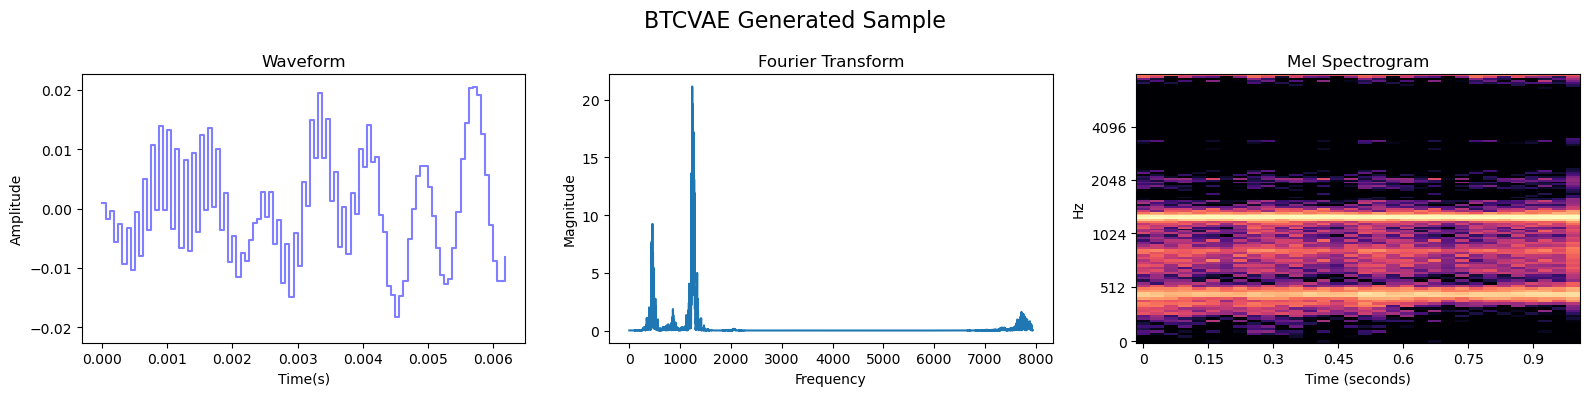

In [32]:
# Assuming vae is your trained VAE model and latent_dim is the dimension of the latent space
# Generate random samples from the latent space
num_samples = 100  # Number of sounds to generate
latent_samples = torch.randn(num_samples, latent_dim).to(device)  # Generate random samples

# Decode the latent samples to generate new sounds
with torch.no_grad():
    vae.eval()
    generated_mel_spectrograms = vae.decode(latent_samples)  # Decode the latent samples

# Random generated mel spectrogram
# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

idx =  np.random.randint(len(generated_mel_spectrograms))
mel_spec = generated_mel_spectrograms[idx].squeeze().detach().cpu().numpy()
waveform = librosa.feature.inverse.mel_to_audio(mel_spec, sr=sr, n_fft=2048, hop_length=512, n_iter=512)

# Waveform
librosa.display.waveshow(waveform[:100], sr=sr, ax=axs[0], alpha=0.5, color='b')
axs[0].set_title('Waveform')
axs[0].set_xlabel('Time(s)')
axs[0].set_ylabel('Amplitude')

# Fourier Transform 
ft = np.fft.fft(waveform)
axs[1].plot(np.abs(ft)[:len(ft)//2])
axs[1].set_title('Fourier Transform')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Magnitude')

# Mel Spectrogram
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), 
                y_axis='mel', x_axis='s', sr=sr, 
                hop_length=hop_length, ax=axs[2])
axs[2].set_title('Mel Spectrogram')  
# axs[2].set_ylabel('Magnitude')
fig.suptitle('BTCVAE Generated Sample', fontsize=16)  
plt.tight_layout()
# save the figure
plt.savefig('./Figures/Generated_sample_BTCVAE.png', dpi=300, bbox_inches='tight')
plt.show()